Spectral analysis
-----------------

Delta power, which we define as sum of the power spectral density between 1hz and 3hz is a well established EEG measure which can be used to discriminate sleep stages [1],[2]. Delta power is increasing along with the depth of the non-rem sleep stage, that is N1 (or NREM1), N2 and N3 a shown in figure below (from [2]):

<img src="images/delta_stages.png", width = 600>

We are going to compare PSG and Neuroon in their abillity to discriminate delta power in sleep stages as this information is important for an eeg based sleep staging [2].

[1] Aeschbach, D., & Borbely, A. a. (1993). All-night dynamics of the human sleep EEG. Journal of Sleep Research. 

[2] Mukai, J., Uchida, S., Miyazaki, S., Nishihara, K., & Honda, Y. (2003). Spectral analysis of all-night human sleep EEG in narcoleptic patients and normal subjects. J Sleep Res, 12(1), 63–71.

In [1]:
%load_ext autoreload
%autoreload 2

import parse_hipnogram as ph
from parse_signal import load_psg, load_neuroon


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal as sig
import seaborn as sns
import h5py
import scipy.signal as sig
from collections import OrderedDict 

from plotting_collection import plot_spectra_by_stage

%matplotlib inline
stage_color_dict = {'N1' : 'royalblue', 'N2' :'forestgreen', 'N3' : 'coral', 'rem' : 'plum', 'wake' : 'lightgray' }


loading


In [2]:
def analyze_sleep_stage_spectrum(night):
    # prep_for_spectral rearrenges the rows to have start timestamp and end timestamp in the same row 

    neuroon_hipnogram = ph.prep_for_spectral(ph.parse_neuroon_stages(night = night))
    psg_hipnogram = ph.prep_for_spectral(ph.parse_psg_stages(night = night))

    # Load the eeg signals
    neuroon_signal =  load_neuroon(night = night)
    psg_signal =  load_psg('F3-A2', night = night)

    # Cut the signal into epochs corresponding to occurence of a sleep stage
    # and calculate the power spectrum for each epoch
    _, neuroon_spectra, neuroon_frequency = make_stage_slices(125, neuroon_hipnogram, neuroon_signal)
    _, psg_spectra, psg_frequency = make_stage_slices(200, psg_hipnogram, psg_signal)


    band = plot_spectra_by_stage(neuroon_spectra, neuroon_frequency,'NeuroOn', min_freq = 1, max_freq = 3)
    band = plot_spectra_by_stage(psg_spectra, psg_frequency,'PSG', min_freq = 1, max_freq = 3)


In [3]:
# Iterate over each case when hipnogram detected a sleep stage and cut a corresponding signal slice
def make_stage_slices(sampling_rate, hipno, signal):
    # Prepare dicts to store the slices and their spectrea with frequency bins information
    slices = {}
    spectra = {}
    frequency = {}
    
    # Iterate over each sleep stage category
    for name, sleep_stage in hipno.groupby('stage_name'):
        stage_spectra = []
        stage_slices = []
        stage_freqs = []
        # iterate over each occurence of a sleep stage
        for idx, phase_event in sleep_stage.iterrows():
            # Cut corresponding slice of eeg signals
            _slice = np.array(signal.loc[phase_event['starts'] : phase_event['ends']])
            # Check if it exists, this will only fail at the last psg slice of the wake phase which lasted for 1 sample...
            if(_slice.size >  1):
                # Store the raw signal
                stage_slices.append(_slice)
                # Compute and store signal spectral density
                freqs, pxx = sig.welch(_slice, fs = sampling_rate, nperseg=1024, noverlap = 256) 
                # pxx is the power density at frequency described by freqs array
                stage_spectra.append(pxx)
                # Save the frequency labels for indices of the pxx
                stage_freqs.append(freqs)
            
        slices[name] = stage_slices
        spectra[name] = np.array(stage_spectra)
        frequency[name] = np.array(stage_freqs)
        
    return slices, spectra, frequency
    
    

/home/alxd/Sketchbook/neuroon/peer-review-project/venv/local/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
parse_hipnogram.py:76: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  neuroon_stages = neuroon_stages.sort(columns = 'timestamp')
/home/alxd/Sketchbook/neuroon/peer-review-project/venv/local/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value

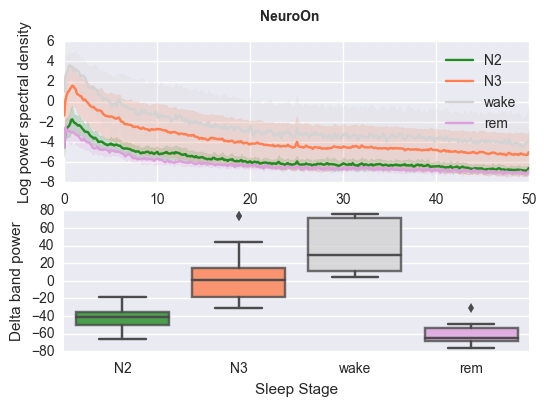

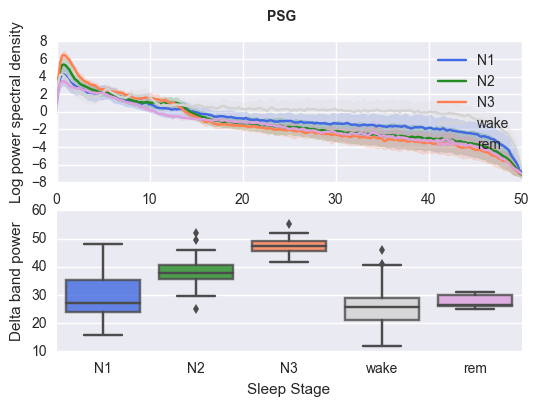

In [4]:
analyze_sleep_stage_spectrum(night = 1)

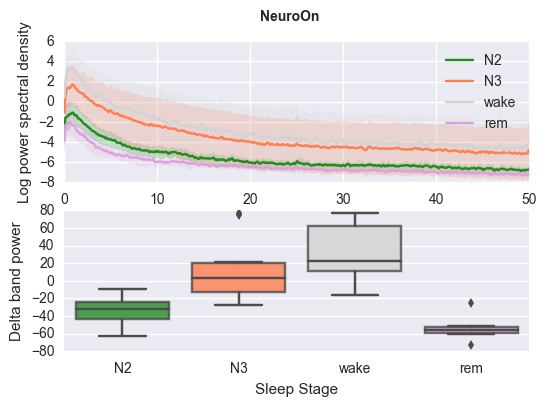

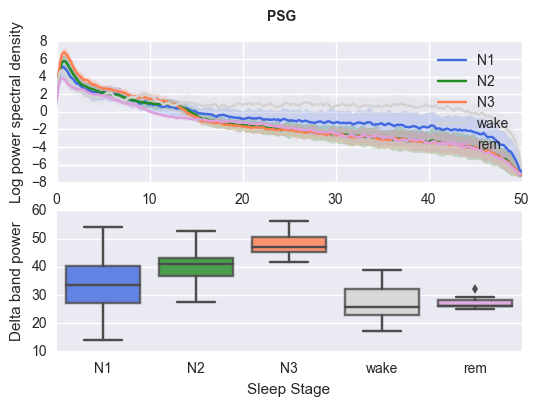

In [5]:
analyze_sleep_stage_spectrum(night = 2)